## Further methylation preprocessing steps

The steps in `1B_preprocess_27K_methylation_data.ipynb` and `1C_preprocess_450K_methylation_data.ipynb` are very basic, so we also wanted to try a few other things that people commonly do before methylation analyses, to make sure that our results aren't dependent on our preprocessing steps (or lack thereof).

To start with, we'll try these things on the 27K data, and we'll extend them to the 450K data later if they seem to have some effect on our results.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from venn import venn

import mpmp.config as cfg
import mpmp.utilities.tcga_utilities as tu

In [2]:
# if SAVE_RESULTS = True, overwrite existing data files generated by this script
# generating results can be slow, so for debugging/visualization without changing
# the data, it may make sense to set this to False
SAVE_RESULTS = False

### Load data

Load methylation data (just 27K for now) and Illumina manifest data.

The Illumina manifest maps probes to their probe type (type I or II), their chromosome/nearest gene, their functional classification (e.g. TSS, gene body, UTR, etc), and lots of other metadata about each probe.

In [3]:
tcga_methylation_df = (
    pd.read_csv(cfg.methylation_27k_data, index_col=0, sep='\t')
      .transpose()
)

print(tcga_methylation_df.shape)
tcga_methylation_df.iloc[:5, :5]

(20040, 11975)


,TCGA-02-0001-01,TCGA-02-0003-01,TCGA-02-0006-01,TCGA-02-0007-01,TCGA-02-0009-01
cg00000292,0.8460,0.732,0.6790,0.8470,0.8550
cg00003994,0.0664,0.131,0.0897,0.0409,0.0661
cg00005847,0.3310,0.839,0.4690,0.3550,0.6050
cg00008493,0.9260,0.934,0.9250,0.9300,0.9270
cg00008713,0.0606,0.165,0.0616,0.0605,0.0614


In [4]:
if os.path.isfile(cfg.methylation_manifest):
    manifest_df = pd.read_csv(
        cfg.methylation_manifest,
        index_col=0
    )
else:
    # if manifest file hasn't already been downloaded, get it from Illumina website
    print('loading manifest from URL')
    manifest_df = pd.read_csv(
        cfg.manifest_url,
        header=7, # skip first 6 lines
        index_col=0
    )
    manifest_df.to_csv(cfg.methylation_manifest)
    
manifest_df.iloc[:5, :5]

/home/jake/anaconda3/envs/mpmp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2,4,11,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq
IlmnID,,,,,
cg00035864,cg00035864,31729416,AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAA...,NaN,NaN
cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAAC...,3.17174e+07,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAAC...
cg00061679,cg00061679,28780415,AAAACATTAAAAAACTAATTCACTACTATTTAATTACTTTATTTTC...,NaN,NaN
cg00063477,cg00063477,16712347,TATTCTTCCACACAAAATACTAAACRTATATTTACAAAAATACTTC...,NaN,NaN
cg00121626,cg00121626,19779393,AAAACTAATAAAAATAACTTACAAACCAAATACTATACCCTACAAC...,NaN,NaN


Text(0.5, 1.0, 'Probe overlap between Illumina manifest and TCGA dataset')

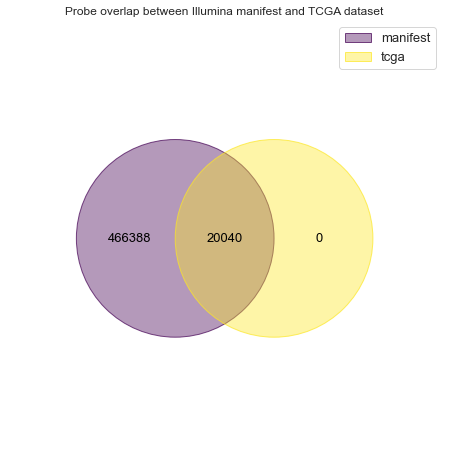

In [5]:
# look at overlap of probes in manifest and probes in TCGA dataset
# all probes in TCGA should be in manifest, but we just want to make sure
manifest_probes = manifest_df.index
tcga_probes = tcga_methylation_df.index

sns.set_style('white')
venn({'manifest': set(manifest_probes),
      'tcga': set(tcga_probes)})
plt.title('Probe overlap between Illumina manifest and TCGA dataset')

In [6]:
# get probe type (type I or type II) for TCGA probes from manifest
tcga_methylation_df = (tcga_methylation_df
    .merge(manifest_df[['Infinium_Design_Type', 'CHR']],
           left_index=True, right_index=True)
    .astype({'CHR': 'str'})
    .rename(columns={'Infinium_Design_Type': 'probe_type',
                     'CHR': 'chromosome'})
)
# check for NA rows, shouldn't be any
print('NA rows: {}'.format(
    tcga_methylation_df.shape[0] - tcga_methylation_df.dropna().shape[0]))
tcga_methylation_df.iloc[:5, -5:]

NA rows: 0


,TCGA-X7-A8D7-11,TCGA-YB-A89D-11,TCGA-ZU-A8S4-11,probe_type,chromosome
cg00000292,0.8800,0.6760,0.7140,II,16
cg00003994,0.0398,0.0536,0.0633,II,7
cg00005847,0.1550,0.3210,0.1530,II,2
cg00008493,0.9420,0.9300,0.9100,II,14
cg00008713,0.0612,0.0695,0.0658,II,18


### Probe filtering

We want to try removing certain classes of methylation probes:

* Probes on sex chromosomes (X or Y chromosome)
* Cross-reactive probes (these were identified in [Chen et al. 2013](https://doi.org/10.4161/epi.23470), we downloaded them using the [maxprobes R package](https://github.com/markgene/maxprobes))

Both of these probe classes could provide spurious signal for classification/regression modeling.

In [7]:
cross_reactive_probes = pd.read_csv(cfg.cross_reactive_probe_list, 
                                    header=None,
                                    index_col=0,
                                    squeeze=True)
cross_reactive_probes.head()

""
0
cg00001510
cg00003969
cg00004121
cg00004192
cg00004209


Text(0.5, 1.0, 'Probe overlap between cross-reactive probe list and TCGA dataset')

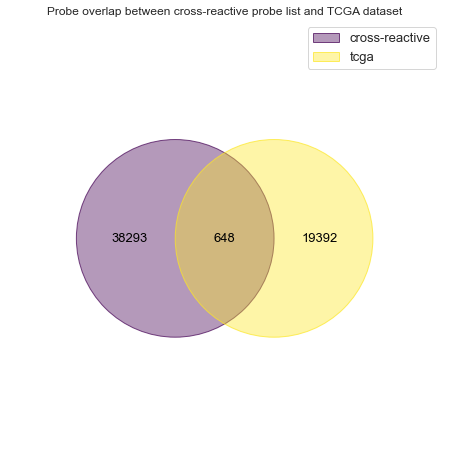

In [8]:
# look at overlap of cross-reactive probes and probes in TCGA dataset
sns.set_style('white')
venn({'cross-reactive': set(cross_reactive_probes.index),
      'tcga': set(tcga_probes)})
plt.title('Probe overlap between cross-reactive probe list and TCGA dataset')

In [9]:
print(tcga_methylation_df.shape)
tcga_methylation_df = (
    tcga_methylation_df[(~tcga_methylation_df.chromosome.isin(['X', 'Y'])) &
                        (~tcga_methylation_df.index.isin(cross_reactive_probes.index))]
)
print(tcga_methylation_df.shape)

(20040, 11977)
(18698, 11977)


In [10]:
if SAVE_RESULTS:
    
    # save probe types
    # BMIQ expects these to be labeled as 1/2 rather than I/II, so change them here
    tcga_methylation_df.loc[tcga_methylation_df.probe_type == 'I', 'probe_type'] = 1
    tcga_methylation_df.loc[tcga_methylation_df.probe_type == 'II', 'probe_type'] = 2
    tcga_methylation_df['probe_type'].to_csv(
        os.path.join(cfg.data_dir, 'methylation_27k_filtered_probe_types.txt')
    )

    # save methylation data without probe metadata
    (tcga_methylation_df
        .drop(columns=['chromosome', 'probe_type'])
        .transpose()
        .to_csv(os.path.join(cfg.data_dir, 'methylation_27k_filtered_probes.tsv'),
                sep='\t')
    )

### Normalize type I vs. type II beta values

This happens on the sample level.

At this point, you should run the `run_bmiq.R` script in the `wateRmelon` conda environment. This should generate the `methylation_27k_bmiq_normalized.tsv` output that we load below.

In [11]:
tcga_norm_df = (
    pd.read_csv(os.path.join(cfg.data_dir, 'methylation_27k_bmiq_normalized.tsv'),
                sep='\t', index_col=0)
      .merge(manifest_df[['Infinium_Design_Type', 'CHR']],
             left_index=True, right_index=True)
      .astype({'CHR': 'str'})
      .rename(columns={'Infinium_Design_Type': 'probe_type',
                       'CHR': 'chromosome'})
      #.transpose()
)
# R replaces hyphens in columns with dots, so we need to switch them back
tcga_norm_df.columns = tcga_norm_df.columns.str.replace('.', '-')
print(tcga_norm_df.shape)
tcga_norm_df.iloc[:5, -5:]

(18698, 11977)


,TCGA-X7-A8D7-11,TCGA-YB-A89D-11,TCGA-ZU-A8S4-11,probe_type,chromosome
cg00000292,0.962568,0.731270,0.766099,II,16
cg00003994,0.019032,0.023878,0.026287,II,7
cg00005847,0.118961,0.314197,0.107466,II,2
cg00008493,0.990638,0.979882,0.974218,II,14
cg00008713,0.029334,0.033075,0.027330,II,18


In [12]:
# there should be some NA samples, these are samples that the beta mixture
# model didn't converge correctly for
print(np.count_nonzero(tcga_norm_df.isna().sum(axis=0)))

106


In [13]:
# we'll just drop the samples with poor convergence, there shouldn't be many of them
tcga_norm_df.dropna(axis='columns', inplace=True)
print(tcga_norm_df.shape)

if SAVE_RESULTS:
    (tcga_norm_df
      .drop(columns=['probe_type', 'chromosome'])
      .transpose()
      .to_csv(os.path.join(cfg.data_dir, 'methylation_27k_bmiq_normalized_nona.tsv'),
              sep='\t'))

(18698, 11871)


In [14]:
from sklearn.decomposition import PCA

pca_dir = os.path.join(cfg.data_dir, 'me_compressed')
os.makedirs(pca_dir, exist_ok=True)

tcga_processed_df = (tcga_norm_df
  .drop(columns=['probe_type', 'chromosome'])
  .transpose()
)

n_pcs_list = [100, 1000, 5000]
var_exp_list = []
pca_file_string = 'me_27k_bmiq_pc{}.tsv.gz'
ve_file_string = 'me_27k_bmiq_pc{}_ve.tsv'

if SAVE_RESULTS:
    for n_pcs in n_pcs_list:
        pca = PCA(n_components=n_pcs, random_state=cfg.default_seed)
        me_pca = pca.fit_transform(tcga_processed_df)
        print(me_pca.shape)
        var_exp_list.append(pca.explained_variance_ratio_)
        me_pca = pd.DataFrame(me_pca, index=tcga_processed_df.index)
        me_pca.to_csv(os.path.join(pca_dir, pca_file_string.format(n_pcs)),
                      sep='\t',
                      float_format='%.3g')
        # save explained variance array to load when SAVE_RESULTS=False
        np.savetxt(os.path.join(pca_dir, ve_file_string.format(n_pcs)),
                   pca.explained_variance_ratio_,
                   fmt='%.4f',
                   delimiter='\t')
else:
    for n_pcs in n_pcs_list:
        # load explained variance array from file, to plot it
        var_exp_list.append(
            np.loadtxt(os.path.join(pca_dir, ve_file_string.format(n_pcs)),
                       delimiter='\t')
        )

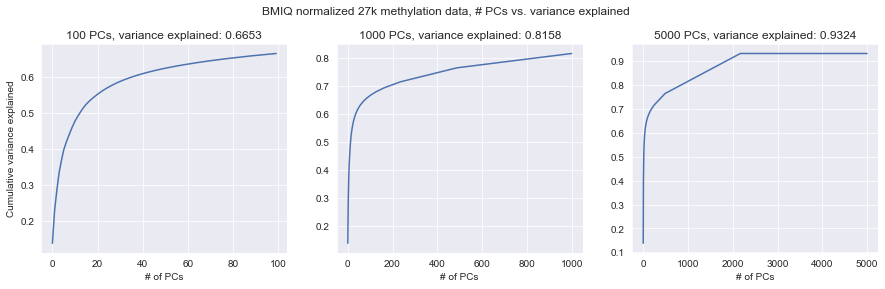

In [15]:
# plot PCA variance explained
# we can only do this if we've calcluated and saved PCA-transformed data
sns.set({'figure.figsize': (15, 4)})
fig, axarr = plt.subplots(1, 3)

for ix, ve in enumerate(var_exp_list):
    sns.lineplot(x=range(len(ve)), y=np.cumsum(ve), ax=axarr[ix])
    axarr[ix].set_title('{} PCs, variance explained: {:.4f}'.format(
        n_pcs_list[ix], sum(ve, 0)))
    axarr[ix].set_xlabel('# of PCs')
    if ix == 0:
        axarr[ix].set_ylabel('Cumulative variance explained')
plt.suptitle('BMIQ normalized 27k methylation data, # PCs vs. variance explained')
plt.subplots_adjust(top=0.85)

### Plot probe intensity distributions

Split probes into type I and type II (based on Illumina manifest info), and plot beta value distributions for each probe type.

In the first distribution plot, we'll take 100 individual probes of each probe type, and plot their beta distributions over all samples (resulting in 200 total distributions, 1 per probe).

In the second plot, we'll take 100 TCGA samples (all samples would be too slow), and look at the beta distribution averaged over all probes of each type (2 total distributions averaging over many probes).

In [16]:
# sample n_samples probes of each type
# using all the samples takes forever to run and produces a plot that's hard to read
def sample_probes(methylation_df, n_samples=100):
    tI_probes = (
        methylation_df[methylation_df.probe_type == 'I']
          .sample(n=n_samples, random_state=cfg.default_seed)
    )
    tII_probes = (
        methylation_df[methylation_df.probe_type == 'II']
          .sample(n=n_samples, random_state=cfg.default_seed)
    )
    return tI_probes, tII_probes

tI_raw, tII_raw = sample_probes(tcga_methylation_df)
tI_norm, tII_norm = sample_probes(tcga_norm_df)

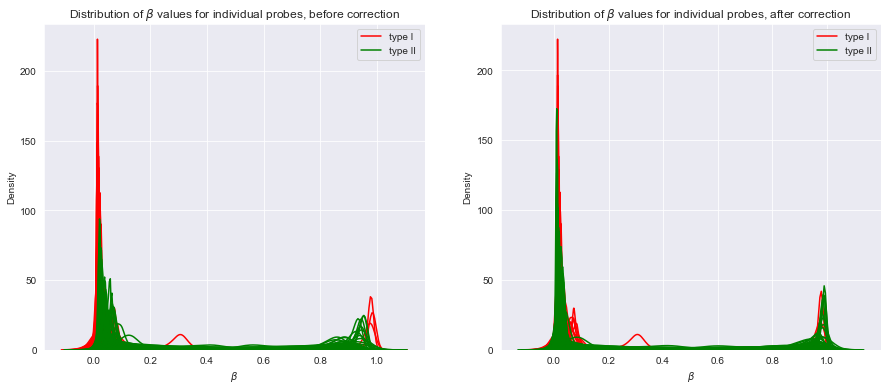

In [17]:
sns.set_style('whitegrid')
sns.set({'figure.figsize': (15, 6)})

fig, axarr = plt.subplots(1, 2)
 
for ix, (probe, row) in enumerate(tI_raw.iterrows()):
    betas = row.values[:-2].astype('float')
    if ix == 0:
        sns.kdeplot(x=betas, color='red', label='type I', ax=axarr[0])
    else:
        sns.kdeplot(x=betas, color='red', ax=axarr[0])
    
for ix, (probe, row) in enumerate(tII_raw.iterrows()):
    betas = row.values[:-2].astype('float')
    if ix == 0:
        sns.kdeplot(x=betas, color='green', label='type II', ax=axarr[0])
    else:
        sns.kdeplot(x=betas, color='green', ax=axarr[0])
    
axarr[0].set_title(r'Distribution of $\beta$ values for individual probes, before correction')
axarr[0].set_xlabel(r'$\beta$')
axarr[0].legend()

for ix, (probe, row) in enumerate(tI_norm.iterrows()):
    betas = row.values[:-2].astype('float')
    if ix == 0:
        sns.kdeplot(x=betas, color='red', label='type I', ax=axarr[1])
    else:
        sns.kdeplot(x=betas, color='red', ax=axarr[1])
    
for ix, (probe, row) in enumerate(tII_norm.iterrows()):
    betas = row.values[:-2].astype('float')
    if ix == 0:
        sns.kdeplot(x=betas, color='green', label='type II', ax=axarr[1])
    else:
        sns.kdeplot(x=betas, color='green', ax=axarr[1])
    
axarr[1].set_title(r'Distribution of $\beta$ values for individual probes, after correction')
axarr[1].set_xlabel(r'$\beta$')
axarr[1].legend()

In [18]:
# single distribution from all probes of each type
# first take all probes from the given number of random samples
def sample_and_aggregate_probes(methylation_df, n_samples=100):
    sampled_df = (methylation_df
        .drop(columns=['probe_type', 'chromosome'])
        .sample(n=n_samples,
                replace=False,
                random_state=cfg.default_seed,
                axis='columns')
    )
    sampled_df['probe_type'] = methylation_df.probe_type

    # split into type I and type II probes
    all_tI_probes = (
        sampled_df[sampled_df.probe_type == 'I']
          .drop(columns=['probe_type'])
          .values.astype('float').flatten()
    )
    all_tII_probes = (
        sampled_df[sampled_df.probe_type == 'II']
          .drop(columns=['probe_type'])
          .values.astype('float').flatten()
    )

    # there should be far more tII than tI probes, just check
    assert len(all_tI_probes) < len(all_tII_probes)

    # downsample number of type II probes to equal number of type I probes
    sampled_tII_probes = np.random.choice(all_tII_probes,
                                          size=all_tI_probes.shape[0],
                                          replace=False)
    
    return all_tI_probes, sampled_tII_probes

tI_raw, tII_raw = sample_and_aggregate_probes(tcga_methylation_df)
tI_norm, tII_norm = sample_and_aggregate_probes(tcga_norm_df)

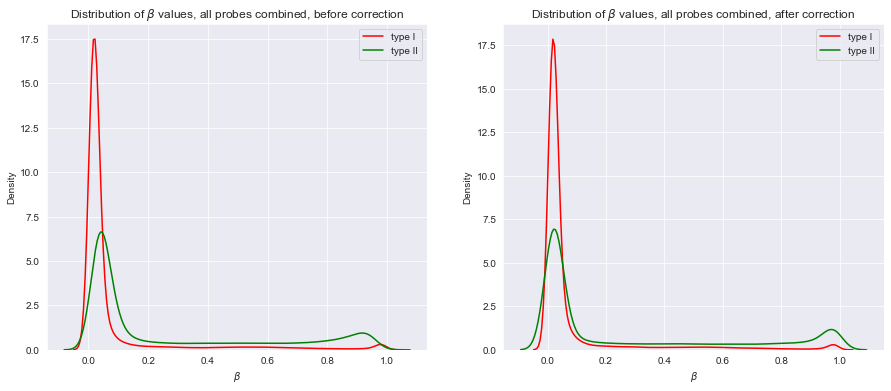

In [19]:
# now plot the aggregate distribution over all the probes
sns.set_style('whitegrid')
sns.set({'figure.figsize': (15, 6)})

fig, axarr = plt.subplots(1, 2)
 
sns.kdeplot(x=tI_raw, color='red', label='type I', ax=axarr[0])
sns.kdeplot(x=tII_raw, color='green', label='type II', ax=axarr[0])
axarr[0].set_title(r'Distribution of $\beta$ values, all probes combined, before correction')
axarr[0].set_xlabel(r'$\beta$')
axarr[0].legend()

sns.kdeplot(x=tI_norm, color='red', label='type I', ax=axarr[1])
sns.kdeplot(x=tII_norm, color='green', label='type II', ax=axarr[1])
axarr[1].set_title(r'Distribution of $\beta$ values, all probes combined, after correction')
axarr[1].set_xlabel(r'$\beta$')
axarr[1].legend()